# Vocoders

- HifiGan (https://github.com/jik876/hifi-gan)
- BigVGAN (https://github.com/NVIDIA/BigVGAN)
 

# Autoencoder

In [1]:
from audiodiffusion.audio_encoder import AudioEncoder

audio_encoder = AudioEncoder.from_pretrained("teticio/audio-encoder")

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
res = audio_encoder.encode(['../cache/spotify_sleep_dataset/waveform/34451.wav'])

In [4]:
res

tensor([[  22.3818,   55.7454,  -45.7355,   75.1192,  -23.6553,    2.2764,
           -5.6201,   25.8378,  -22.7567,   -9.3860,    6.8996,   47.9845,
          -11.0239,   49.9943,   -0.5887,   49.8197,   49.5274,   26.3963,
          -17.9764,  -40.2608,  -17.1629,   36.9612,    6.8959,   66.1374,
          -47.4549,  102.3774,  -60.5647,   41.7779,   47.6061,   46.9786,
           37.0211,   -0.6458,    7.7834,   28.1121,  -28.0773,   24.0048,
          117.4891,  -16.0868,    7.5550,   77.5549,   -2.5127,  -34.7640,
           21.7094,  -20.7481,    2.5825,   23.3617,   42.8699,  -48.1933,
           91.7696,    6.7337,    1.7964,  -20.1088,    7.7989, -119.0542,
          -14.9786,  -59.8400,   16.3396,  -26.4516,   22.9039,   29.4709,
          -40.1346,  -40.8496,  -21.7695,   51.7043,  -15.3641,  -53.3828,
          -54.8138,    4.8525,  -65.6569,  -29.4963,  -75.1400,   16.7820,
          -22.5073,  -34.0118,  -15.1272,  -40.8402,    2.3038,   -9.5547,
           -9.3951,   26.

In [6]:
len(res[0])

100

In [1]:
from audiodiffusion.utils import convert_ldm_to_hf_vae

/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Testing Pre-trained Vocoders

In [1]:
import pyarrow.parquet as pq
import pickle
import torch
from datasets import load_dataset, load_from_disk
from torchvision.transforms import Compose, Normalize, ToTensor

import matplotlib.pyplot as plt
from PIL import Image

def load_my_dataset(dataset_path):
    # dataset_name = '../cache/spotify_sleep_dataset/waveform_small/mel_spectrogram_256_256'
    dataset_config_name = None
    vae = None

    dataset = load_from_disk(
        dataset_path,
        storage_options=dataset_config_name)["train"]
    
    train_batch_size = 16

    # Determine image resolution
    resolution = dataset[0]["image"].height, dataset[0]["image"].width

    augmentations = Compose([
        ToTensor(),
        Normalize([0.5], [0.5]),
    ])

    vqvae = None
    def transforms(examples):
        if vae is not None and vqvae.config["in_channels"] == 3:
            images = [
                augmentations(image.convert("RGB"))
                for image in examples["image"]
            ]
        else:
            images = [augmentations(image) for image in examples["image"]]
        if encodings is not None:
            encoding = [encodings[file] for file in examples["audio_file"]]
            return {"input": images, "encoding": encoding}
        return {"input": images}

    dataset.set_transform(transforms)
    train_dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=train_batch_size, shuffle=True)

    encodings = None
    if encodings is not None:
        encodings = pickle.load(open(encodings, "rb"))
        
    return dataset

def show_image(index, dataset):
    # Access the image at the specified index
    item = dataset[index]
    # Convert the tensor image to a PIL image
    image_tensor = item["input"].squeeze(0)  # Remove batch dimension if present
    
    # Check if the image tensor has 3 dimensions (C, H, W)
    if image_tensor.dim() == 3:
        # Permute the dimensions to (H, W, C)
        image_tensor = image_tensor.permute(1, 2, 0)
    else:
        # Add an extra dimension to mimic grayscale as RGB (for consistent handling)
        image_tensor = image_tensor.unsqueeze(2).repeat(1, 1, 3)

    # Denormalize the image tensor
    print(image_tensor.shape)
    image_tensor = (image_tensor * 0.5 + 0.5) * 255
    print(image_tensor.shape)
    image = Image.fromarray(image_tensor.numpy().astype('uint8'))
    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()


/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ssd_64_64_path = '../cache/spotify_sleep_dataset/waveform_small/mel_spec_64_64'
ssd_64_64 = load_my_dataset(ssd_64_64_path)

In [28]:
ds_256_256_path = '../cache/drum_samples/small_mel_spec_256_256'
ds_256_256 = load_my_dataset(ds_256_256_path)

In [29]:
ds_256_256

Dataset({
    features: ['image', 'audio_file', 'slice'],
    num_rows: 16
})

In [30]:
mel_spec_0 = ds_256_256[0]['input']

In [31]:
mel_spec_0.shape

torch.Size([1, 256, 256])

#### Interpolate/resize mel spec from 64,64 to 80,256

In [32]:
import torch
import torch.nn.functional as F

In [33]:
mel_spec_0.unsqueeze(1).shape

torch.Size([1, 1, 256, 256])

In [34]:
import numpy as np

def visualize_tensor(tensor):
    """
    Visualize a 3D tensor as an image.
    
    Parameters:
    - tensor (torch.Tensor): A 3D tensor of shape [1, height, width].
    
    Note:
    - Automatically scales tensor values to be between 0 and 1 if they are not already in the range.
    """
    if tensor.ndim != 3 or tensor.shape[0] != 1:
        raise ValueError("Input tensor must be 3D with shape [1, height, width]")

    # Remove the channel dimension and convert to numpy for easier processing
    image = tensor.squeeze().numpy()

    # Check and scale the tensor values if necessary
    if np.any(image < -1) or np.any(image > 1):
        # Normalize to 0-1 from any range
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
    elif np.all(image >= -1) and np.all(image <= 1) and np.any(image < 0):
        # Scale from -1-1 to 0-1
        image = (image + 1) / 2

    # Plot the image
    plt.figure(figsize=(10, 5))
    plt.imshow(image, aspect='auto', cmap='viridis')
    plt.colorbar()  # Add a colorbar to show the scale
    plt.title("Visual Representation of the Tensor")
    plt.xlabel("Time Steps")
    plt.ylabel("Frequency Bins")
    plt.show()

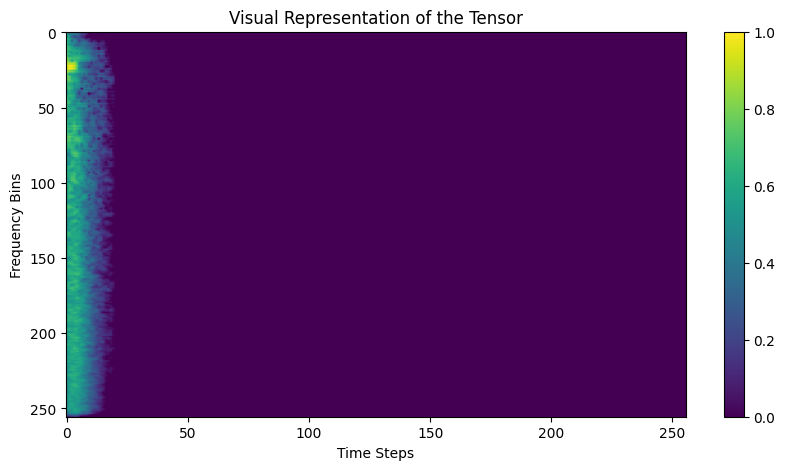

In [35]:
visualize_tensor(mel_spec_0)

In [36]:
# Resizing the spectrogram to (80, 256)
mel_resized = F.interpolate(mel_spec_0.unsqueeze(1), size=(80, 256), mode='bilinear', align_corners=False).squeeze(1)

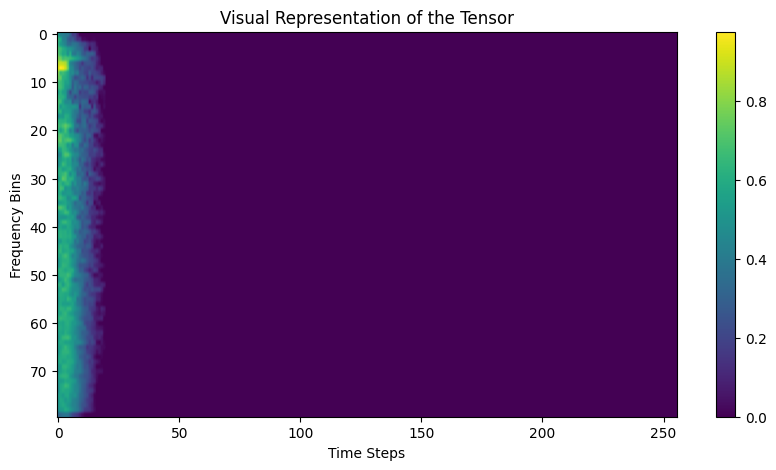

In [37]:
visualize_tensor(mel_resized)

In [38]:
import torch

from vocos import Vocos

vocos = Vocos.from_pretrained("BSC-LT/vocos-mel-22khz")

audio = vocos.decode(mel_resized)

In [39]:
audio.shape

torch.Size([1, 65536])

In [40]:
Audio(data=audio, rate=mel.get_sample_rate())

In [14]:
import torch
import torchaudio

# Assuming 'audio' is your tensor with shape [1, 65536]
# Specify the sample rate of your audio, commonly 44100 or 16000 Hz
sample_rate = 22050

# Specify the path where you want to save the file, including the file name
output_path = '../testing/resized_test_vocoder.wav'

# Save the audio tensor to a WAV file
torchaudio.save(output_path, audio, sample_rate)


In [41]:
mel_spec_0.shape

torch.Size([1, 256, 256])

In [42]:
import sys
# we want this script to first look into the local directory, rather than the installed audiodiffusion library
sys.path.insert(0, '/home/th716/audio-diffusion/')
print(sys.path)

from audiodiffusion.mel import Mel

['/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/notebooks', '/home/th716/.conda/envs/audiodiff_env/lib/python311.zip', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11/lib-dynload', '', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages', '/home/th716/audio-diffusion/src/latent-diffusion', '/home/th716/audio-diffusion/src/taming-transformers', '/tmp/tmpaga8jic5']


In [43]:
# These are the default parameters. If you change any of them, you may have to adjust the others.
mel = Mel(x_res=256,
          y_res=256,
          hop_length=256,
          sample_rate=22050,
          n_fft=1024,
          n_iter=32)

In [44]:
type(mel_spec_0)

torch.Tensor

In [45]:
audio = mel.tensor_to_audio(mel_spec_0)

In [46]:
audio.shape

(65280,)

In [47]:
from IPython.display import Audio


Audio(data=audio, rate=mel.get_sample_rate())

In [50]:
audio_file = "../cache/drum_samples/waveform_small/sample_52.wav"

In [65]:
import sys
# we want this script to first look into the local directory, rather than the installed audiodiffusion library
sys.path.insert(0, '/home/th716/audio-diffusion/')
print(sys.path)

from audiodiffusion.mel import Mel

['/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/', '/home/th716/audio-diffusion/notebooks', '/home/th716/.conda/envs/audiodiff_env/lib/python311.zip', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11/lib-dynload', '', '/home/th716/.conda/envs/audiodiff_env/lib/python3.11/site-packages', '/home/th716/audio-diffusion/src/latent-diffusion', '/home/th716/audio-diffusion/src/taming-transformers', '/tmp/tmpaga8jic5']


In [66]:
# These are the default parameters. If you change any of them, you may have to adjust the others.
mel = Mel(x_res=256,
          y_res=256,
          hop_length=256,
          sample_rate=22050,
          n_fft=1024,
          n_iter=32)

mel.load_audio(audio_file)

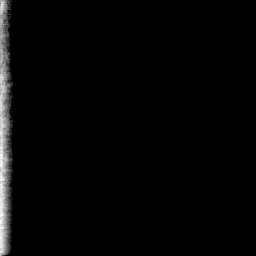

In [67]:
image = mel.audio_slice_to_image(0)
image

In [68]:
image.width, image.height

(256, 256)

In [73]:
type(image)

PIL.Image.Image

In [74]:
import torchvision.transforms as transforms

transform = transforms.ToTensor()
tensor = transform(image)

In [71]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())

In [81]:
audio = mel.tensor_to_audio(tensor)
Audio(data=audio, rate=mel.get_sample_rate())